# Documentation Figures


In [1]:
%matplotlib inline
from __future__ import print_function, division
import sys
sys.path.append('..')
import os
os.chdir("..")
import matplotlib.pyplot as plt
import numpy as np
import vessel_scoring.models
from vessel_scoring.models import train_model_on_data
from vessel_scoring import data, utils
import vessel_scoring.colspec
# import vessel_scoring.evaluate_model_new as evmodel
from vessel_scoring.evaluate_model import evaluate_model, compare_models
from IPython.core.display import display, display_html, HTML, Markdown, publish_display_data
from sklearn import metrics
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Load training and test data

# Data supplied by Kristina
all_lline_kristina, train_lline_kristina,  valid_lline_kristina, test_lline_kristina = data.load_dataset_by_vessel(
        'datasets/kristina_longliner.measures.npz')
all_trawl_kristina, train_trawl_kristina,  valid_trawl_kristina, test_trawl_kristina = data.load_dataset_by_vessel(
        'datasets/kristina_trawl.measures.npz')
all_pseine_kristina, train_pseine_kristina, valid_pseine_kristina, test_pseine_kristina = data.load_dataset_by_vessel(
        'datasets/kristina_ps.measures.npz')

# Crowd sourced longliner data
all_lline_crowd_alex, train_lline_crowd_alex, valid_lline_crowd_alex, test_lline_crowd_alex = data.load_dataset_by_vessel(
        "datasets/classified-filtered.measures.npz")


# # Crowd sourced data from DavidK's setup
# _, train_lline_crowd_new, valid_lline_crowd_new, test_lline_crowd_new = data.load_dataset_by_vessel(
#         "../datasets/id_fishing_points_longliner_classified_tracks.measures.npz")

# test_lline_crowd = utils.concat_common_fields(test_lline_crowd_new, test_lline_crowd_alex)

# _, train_trawl_crowd_new, valid_trawl_crowd_new, test_trawl_crowd_new  = data.load_dataset_by_vessel(
#         "../datasets/id_fishing_points_trawler_classified_tracks.measures.npz")

# all_pseine_crowd, train_pseine_crowd_new, valid_pseine_crowd_new, test_pseine_crowd_new  = data.load_dataset_by_vessel(
#         "../datasets/id_fishing_points_purse_seine_classified_tracks.measures.npz")


# Slow transits (used to train models to avoid classifying slow transits as fishing)
TRANSIT_WEIGHT = 10
x_tran, xtrain_tran, xcross_tran, xtest_tran = data.load_dataset_by_vessel(
                                    'datasets/slow-transits.measures.npz', even_split=False)

train_tran = utils.concatenate_different_recarrays([xtrain_tran, xcross_tran] * TRANSIT_WEIGHT)

train_base =  utils.concatenate_different_recarrays([train_trawl_kristina, train_lline_kristina, train_pseine_kristina, 
            valid_lline_kristina, valid_trawl_kristina, valid_pseine_kristina]
#             train_lline_crowd_new[::2], train_lline_crowd_alex[::2], train_trawl_crowd_new, train_pseine_crowd_new, 
#             valid_lline_crowd_new[::2], valid_lline_crowd_alex[::2], valid_trawl_crowd_new, valid_pseine_crowd_new
                                        )

train_lline = utils.concatenate_different_recarrays([train_lline_kristina, valid_lline_kristina] 
#                 train_lline_crowd_new[::2], train_lline_crowd_alex[::2], 
#                 valid_lline_crowd_new[::2], valid_lline_crowd_alex[::2], 
                                          + [train_tran] * TRANSIT_WEIGHT)

train_trawl = utils.concatenate_different_recarrays([train_trawl_kristina, valid_trawl_kristina]
#                                          train_trawl_crowd_new, valid_trawl_crowd_new,
                                          + [train_tran] * TRANSIT_WEIGHT)

train_pseine = utils.concatenate_different_recarrays([train_pseine_kristina, valid_pseine_kristina] 
                                        #train_pseine_kristina, valid_pseine_crowd_new,
                                         + [train_tran] * TRANSIT_WEIGHT)

train = utils.concatenate_different_recarrays([train_base, train_tran])

Warning, insufficient items to sample, returning all


vessel_scoring/data.py:89: UserWarning: Warning, inufficient items to sample, returning 4430
  warnings.warn("Warning, inufficient items to sample, returning {}".format(len(x)))
vessel_scoring/data.py:89: UserWarning: Warning, inufficient items to sample, returning 2084
  warnings.warn("Warning, inufficient items to sample, returning {}".format(len(x)))


In [3]:
train_base['measure_speedavg_21600'].mean()

0.64278963288412005

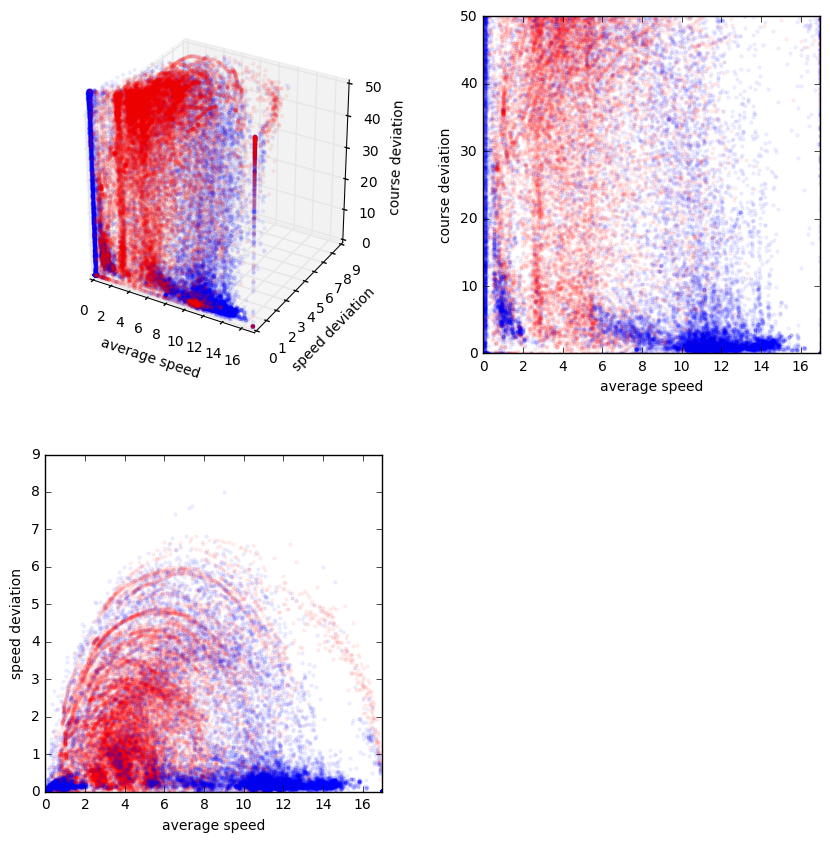

In [4]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('average speed')
    ax.set_xlim(0, 17)
for ax in [ax1, ax3]:
    ax.set_ylabel('speed deviation')
    ax.set_ylim(0, 9)
for ax in [ax1]:
    ax.set_zlabel('course deviation')
    ax.set_zlim(0, 50)

ax2.set_ylabel('course deviation')
ax2.set_ylim(0, 50)
    
fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.3)

is_fishing = utils.is_fishy(train_base)

avg_speed = 17 * (1 - train_base['measure_speedavg_21600'])
speed_deviation = 17 * train_base['measure_speedstddev_21600']
# Note that this is only approximately the standard deviation of the course since we use
# the cos/sin trick to get around branch cut at 2 Pi.
course_deviation = train_base['measure_coursestddev_21600']  * 180 / np.pi * np.sqrt(2)

alpha = 0.05

ax1.scatter(avg_speed[is_fishing], 
           speed_deviation[is_fishing], 
           course_deviation[is_fishing], marker='.', c='#FF0000', alpha=alpha, edgecolors='face')
ax1.scatter(avg_speed[~is_fishing], 
           speed_deviation[~is_fishing], 
           course_deviation[~is_fishing], marker='.', c='#0000FF', alpha=alpha, edgecolors='face')

ax2.scatter(avg_speed[is_fishing], 
           course_deviation[is_fishing], marker='.', c='#FF0000', alpha=alpha, edgecolors='face')
ax2.scatter(avg_speed[~is_fishing], 
           course_deviation[~is_fishing], marker='.', c='#0000FF', alpha=alpha, edgecolors='face')


ax3.scatter(avg_speed[is_fishing], 
           speed_deviation[is_fishing], marker='.', c='#FF0000', alpha=alpha, edgecolors='face')
ax3.scatter(avg_speed[~is_fishing], 
           speed_deviation[~is_fishing], marker='.', c='#0000FF', alpha=alpha, edgecolors='face')

plt.show()

In [5]:
# evmodel.plot_vessel_track(train_lline, 224259000)

## How much test data do we have

Our initial test and training data consisted of roughly a dozen different vessels of each type 
classified over a multi-year period by Kristina Boerder of Dalhousie University. One-quarter of 
those are used for testing, so there is a relatively small number of different vessels in the test
sets. 

In addition, we are beginning to collect crowd sourced data for both testing and training. Some of the
early crowd sourced data, available for long liners only, is used as an additional test set in the examples
below.

In [6]:
for name, all_data, test_data in [("trawlers", all_trawl_kristina, test_trawl_kristina),
                        ("purse seiners", all_pseine_kristina, test_pseine_kristina),
                        ("longliners", all_lline_kristina, test_lline_kristina),
                        ("lonflinwea alex", all_lline_crowd_alex, train_lline_crowd_alex),
                        ("transits", x_tran, xtest_tran),
                        ("transits (training)", x_tran, train_tran),                      
                       ]:
    mmsi_count = len(set(test_data['mmsi']))
    pt_count = len(test_data) 
    fishing_fraction = utils.is_fishy(test_data).sum() / pt_count
    print("For {0} we have {1} test vessels with {2} test points; {3}% of the are fishing".format(
            name, mmsi_count, pt_count, 100 * fishing_fraction))
    print("\t  {0} total vessels with {1} points".format(
            len(set(all_data['mmsi'])), len(all_data)))
    
print("Total training", len(train_tran) / 10 + len(train_base))
print("train tran", len(train_tran) / 10)

For trawlers we have 3 test vessels with 5000 test points; 57.34% of the are fishing
	  6 total vessels with 828162 points
For purse seiners we have 3 test vessels with 5000 test points; 3.72% of the are fishing
	  7 total vessels with 398897 points
For longliners we have 2 test vessels with 5000 test points; 76.7% of the are fishing
	  16 total vessels with 569504 points
For lonflinwea alex we have 55 test vessels with 10000 test points; 50.0% of the are fishing
	  118 total vessels with 324166 points
For transits we have 1 test vessels with 2259 test points; 0.0% of the are fishing
	  4 total vessels with 9038 points
For transits (training) we have 3 test vessels with 65140 test points; 0.0% of the are fishing
	  4 total vessels with 9038 points
Total training 51514.0
train tran 6514.0


In [7]:
# TODO: Automate

md = """

|              |Vessels | Points | Training Points | Validation Points|
|:-------------|:------:|:------:|:---------------:|:----------------:|
| Longliner    | 16     |569,504 | 15,000          | 5000             |
| Trawler      | 6      |828,162 | 15,000          | 5000             |
| Purse Seine  | 7      |398,897 | 15,000          | 5000             |
| Slow Transits| 2      |9,038   | 6,514           |        &nbsp;    |

"""

display(Markdown(md))



|              |Vessels | Points | Training Points | Validation Points|
|:-------------|:------:|:------:|:---------------:|:----------------:|
| Longliner    | 16     |569,504 | 15,000          | 5000             |
| Trawler      | 6      |828,162 | 15,000          | 5000             |
| Purse Seine  | 7      |398,897 | 15,000          | 5000             |
| Slow Transits| 2      |9,038   | 6,514           |        &nbsp;    |



In [8]:
md = """
| |Predicted fishing classified<br/>correctly (precision)|Fishing captured<br/>(recall)|Non–fishing classified as<br/>fishing (false positive rate)|
|:-------------------------------------------------|:-----------------------:|:-----------------------------------------------------:|:---:|
|Longliner   | 97% | 78%  |  9% |
|Trawler     | 93% | 91%  | 10% |
|Purse Seine | 11% | 73%  | 22% |

"""

display(Markdown(md))


| |Predicted fishing classified<br/>correctly (precision)|Fishing captured<br/>(recall)|Non–fishing classified as<br/>fishing (false positive rate)|
|:-------------------------------------------------|:-----------------------:|:-----------------------------------------------------:|:---:|
|Longliner   | 97% | 78%  |  9% |
|Trawler     | 93% | 91%  | 10% |
|Purse Seine | 11% | 73%  | 22% |



In [9]:
import IPython.core.display as _display
import IPython.core
dir(_display)
dir(IPython.core)
from IPython.core import oinspect

In [10]:
# Prepare the models

from vessel_scoring.legacy_heuristic_model import LegacyHeuristicModel
from vessel_scoring.logistic_model import LogisticModel
from vessel_scoring.random_forest_model import RandomForestModel


test_data = {'Long liners': test_lline_kristina, 
             'Long liners - crowd': test_lline_crowd_alex,
             'Trawlers': test_trawl_kristina, 
             'Purse seiners': test_pseine_kristina,
             }




GEARS = [('ps', 'Purse seiners'),
         ('trawl', 'Trawlers'),
         ('longliner', 'Long liners'),
         ('longliner', 'Long liners - crowd'),
        ]

## Model Comparisons

The models output a numbers between 0 and 1 that correspond to how 
confident they are that there is fishing occuring. For
the first set of comparisons we treat predictions `>0.5`
as fishing and those `<=0.5` as nonfishing. This allows us to use
*precision*, *recall* and *f1-score* as metrics. We also show Receiver
Operator Characteristic (ROC) area under the curve (AUC) plots and 
precision recall plots.

Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Training Logistic...


vessel_scoring/data.py:89: UserWarning: Warning, inufficient items to sample, returning 5284
  warnings.warn("Warning, inufficient items to sample, returning {}".format(len(x)))


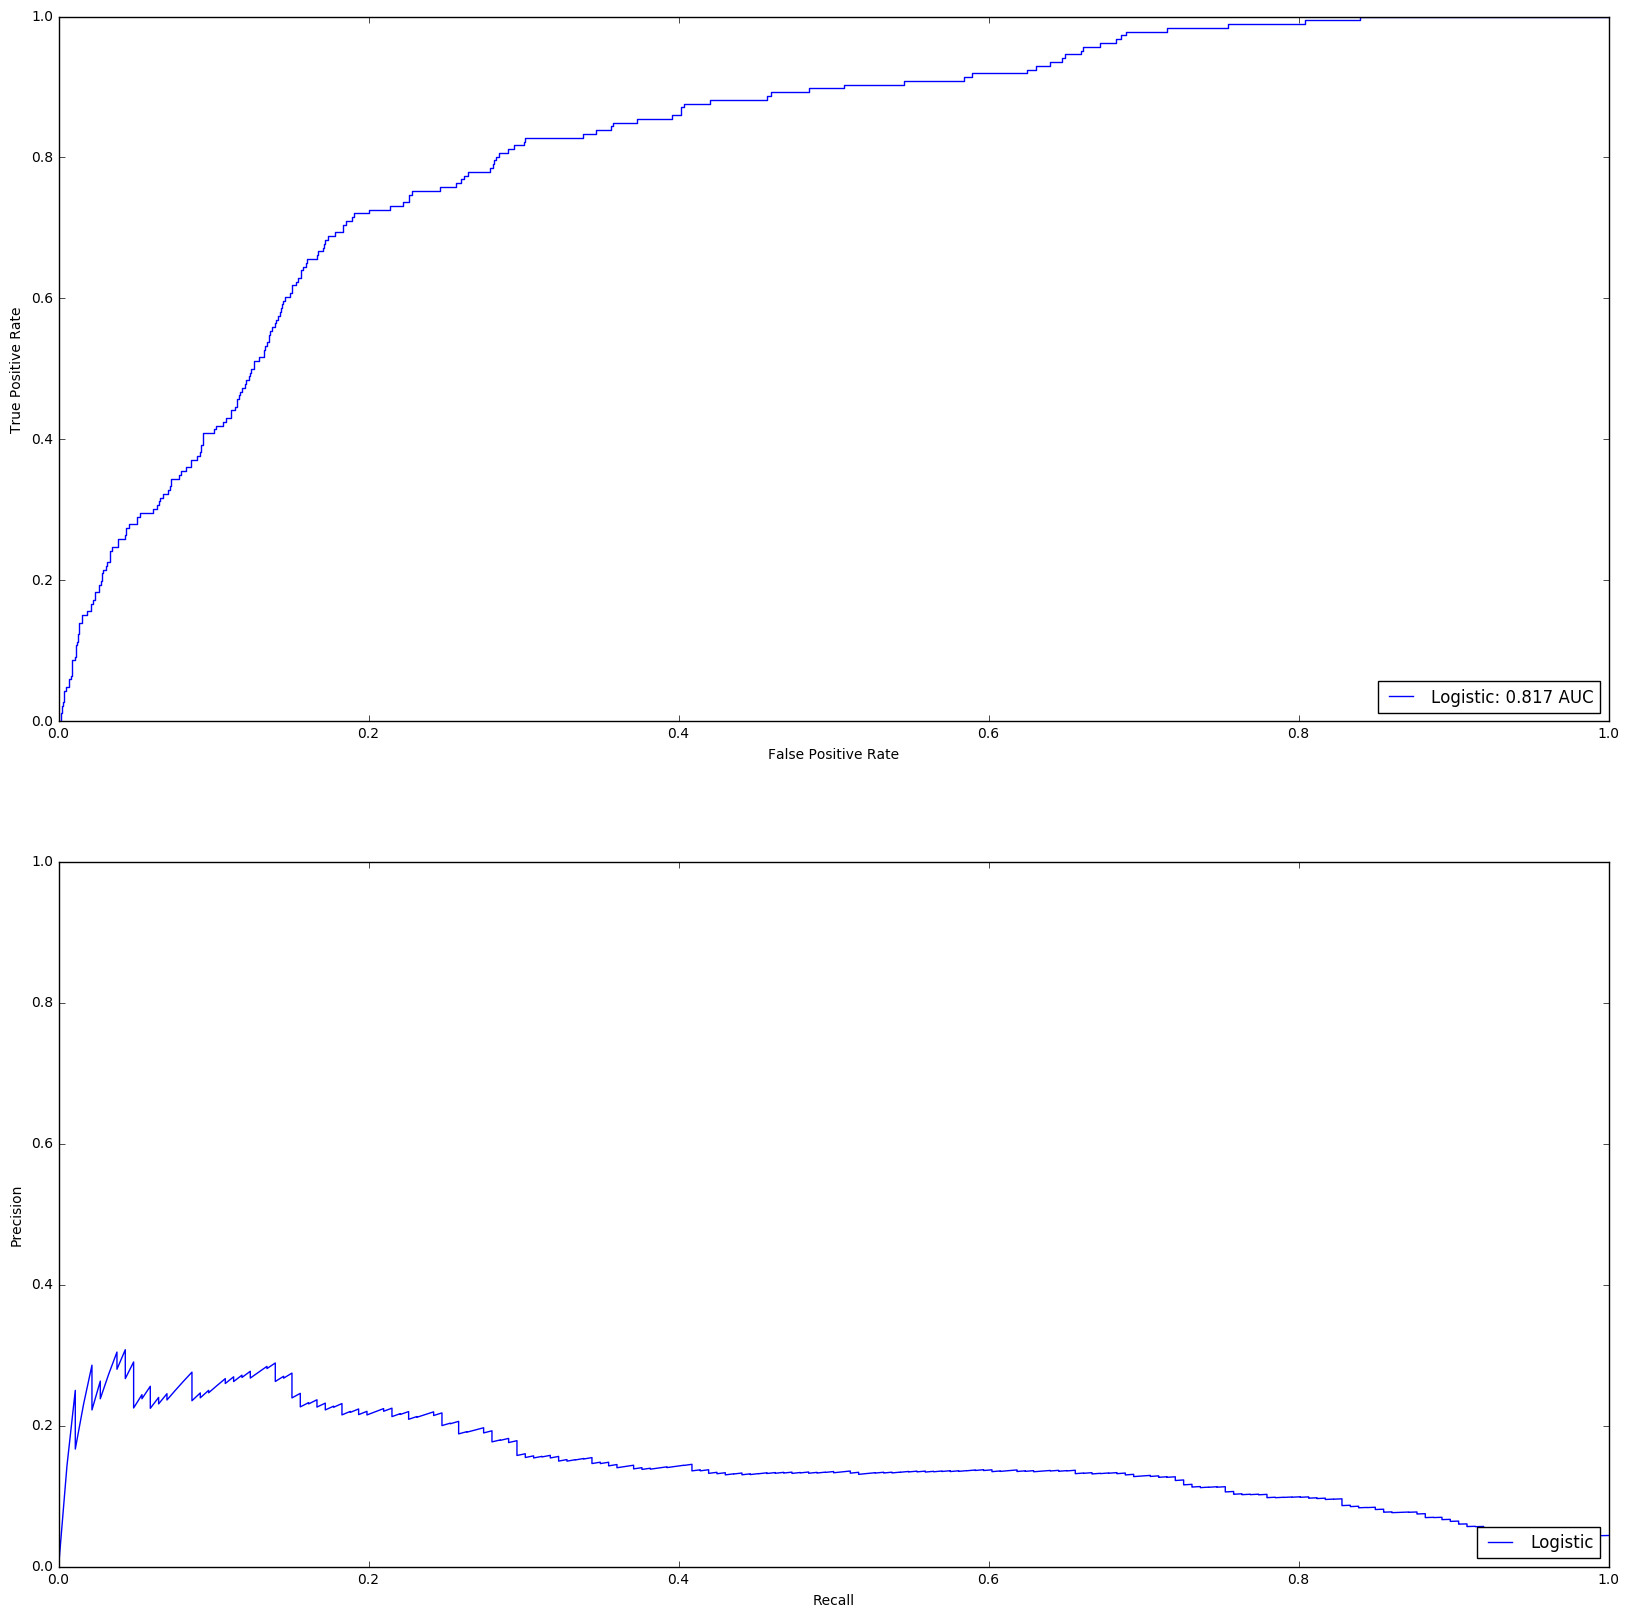

Training Logistic...


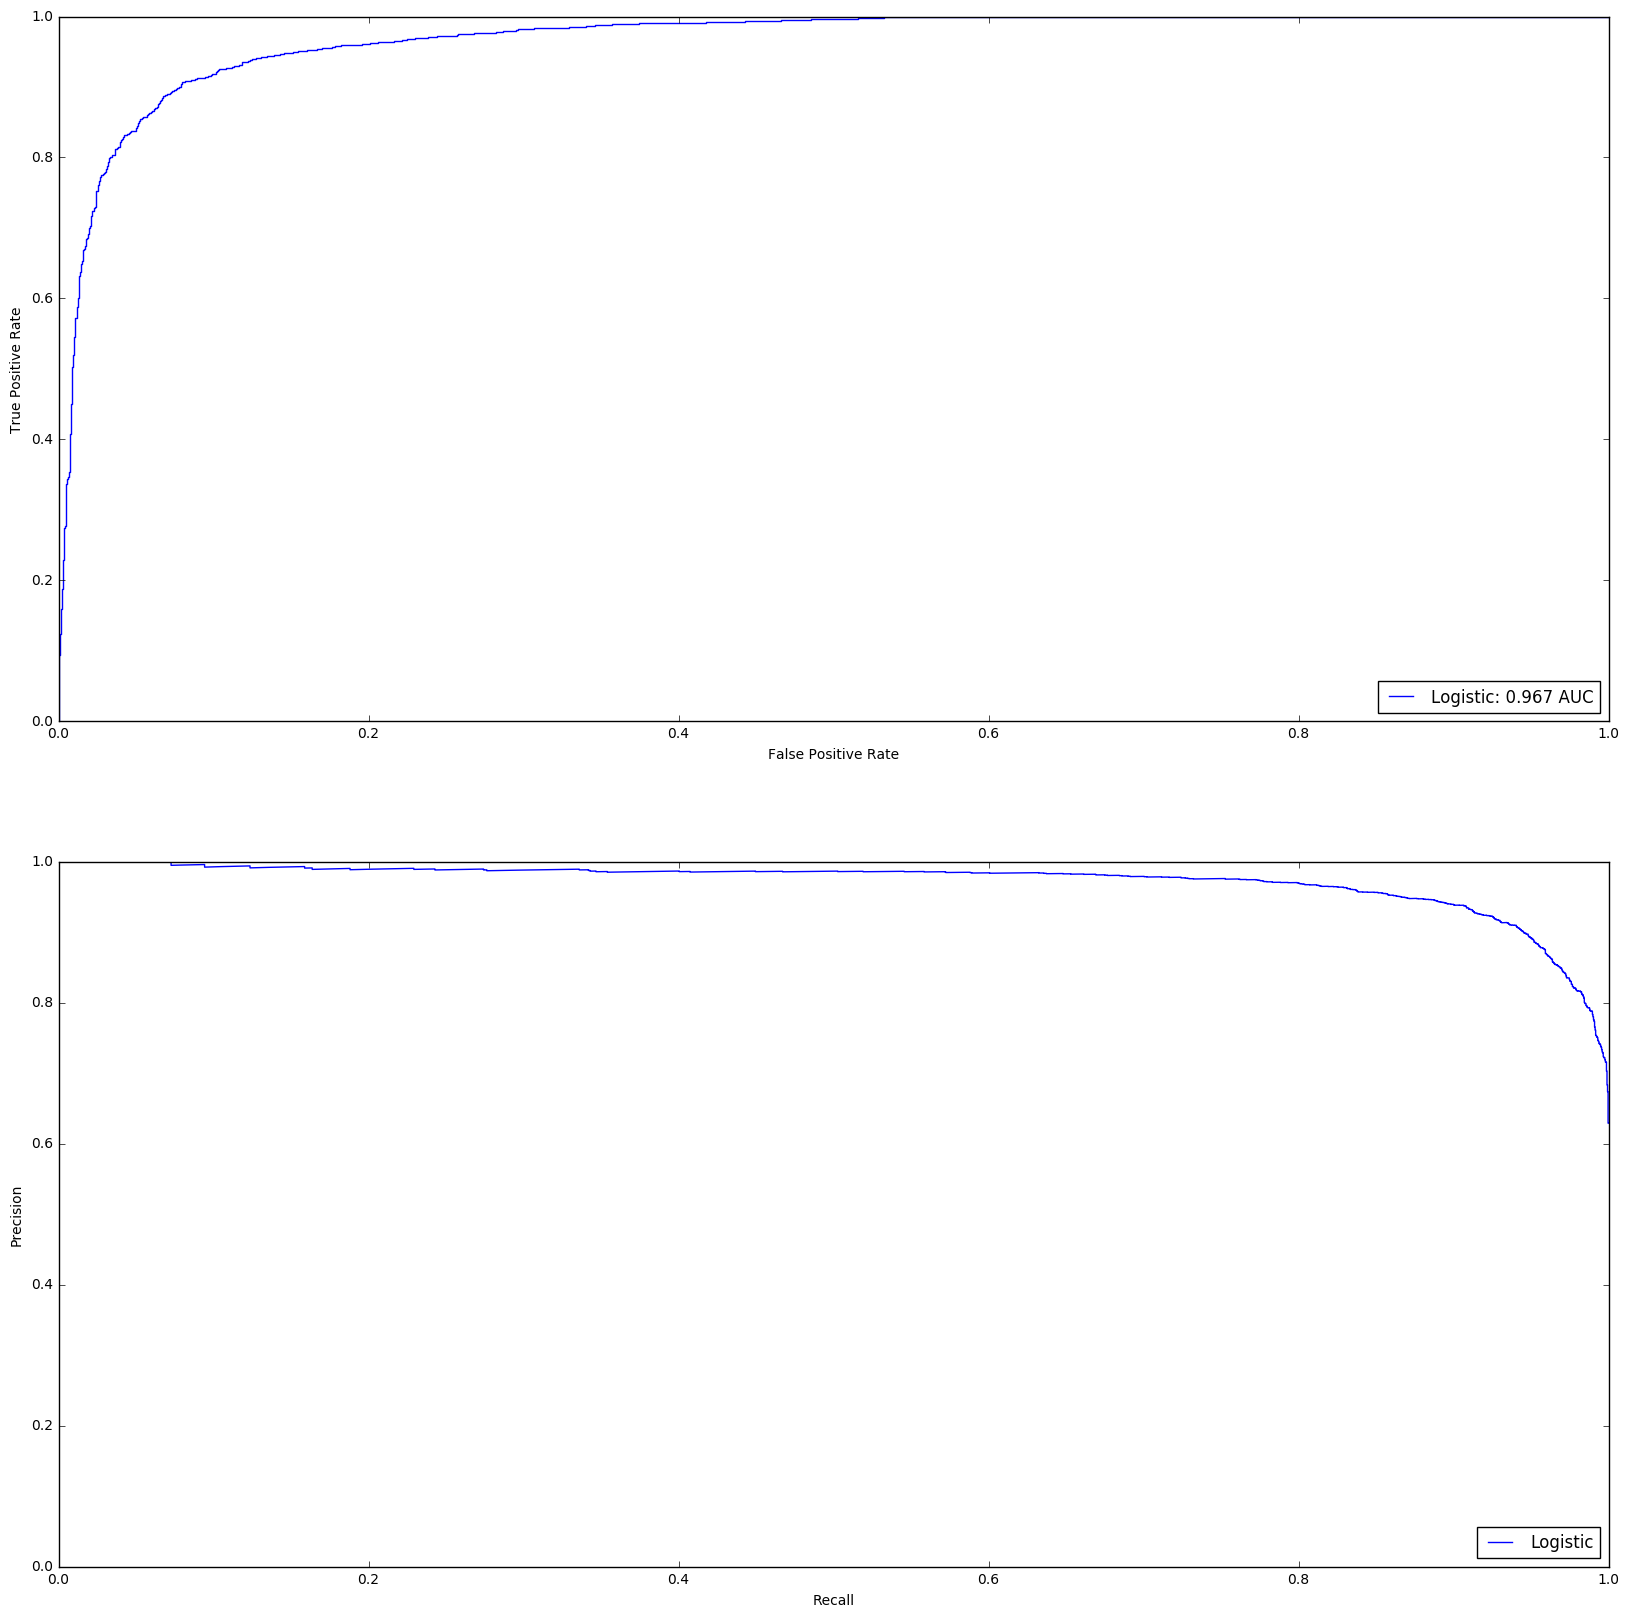

Training Logistic...


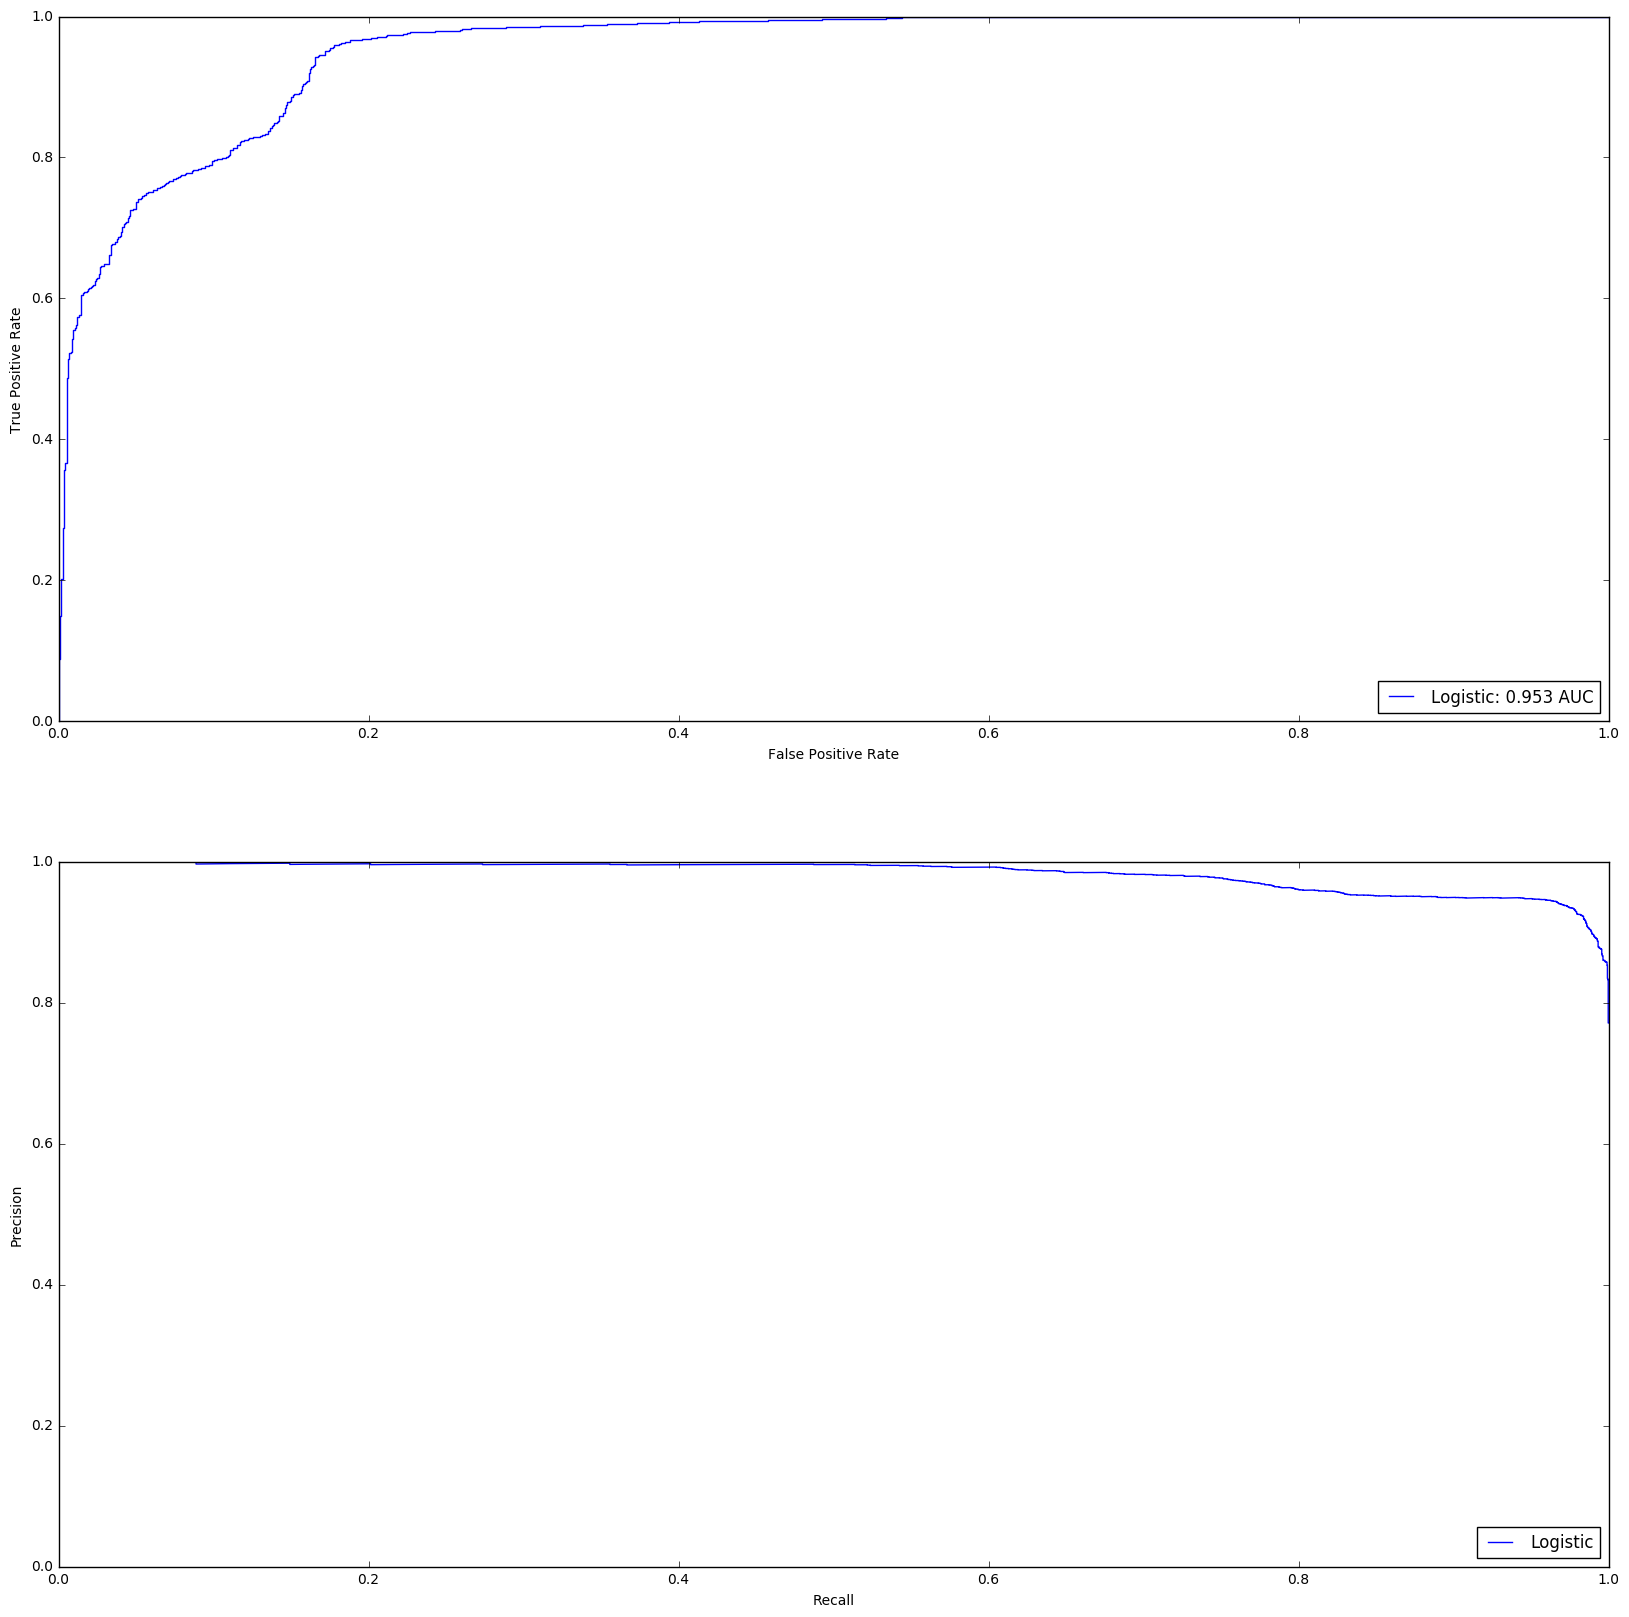

Training Logistic...


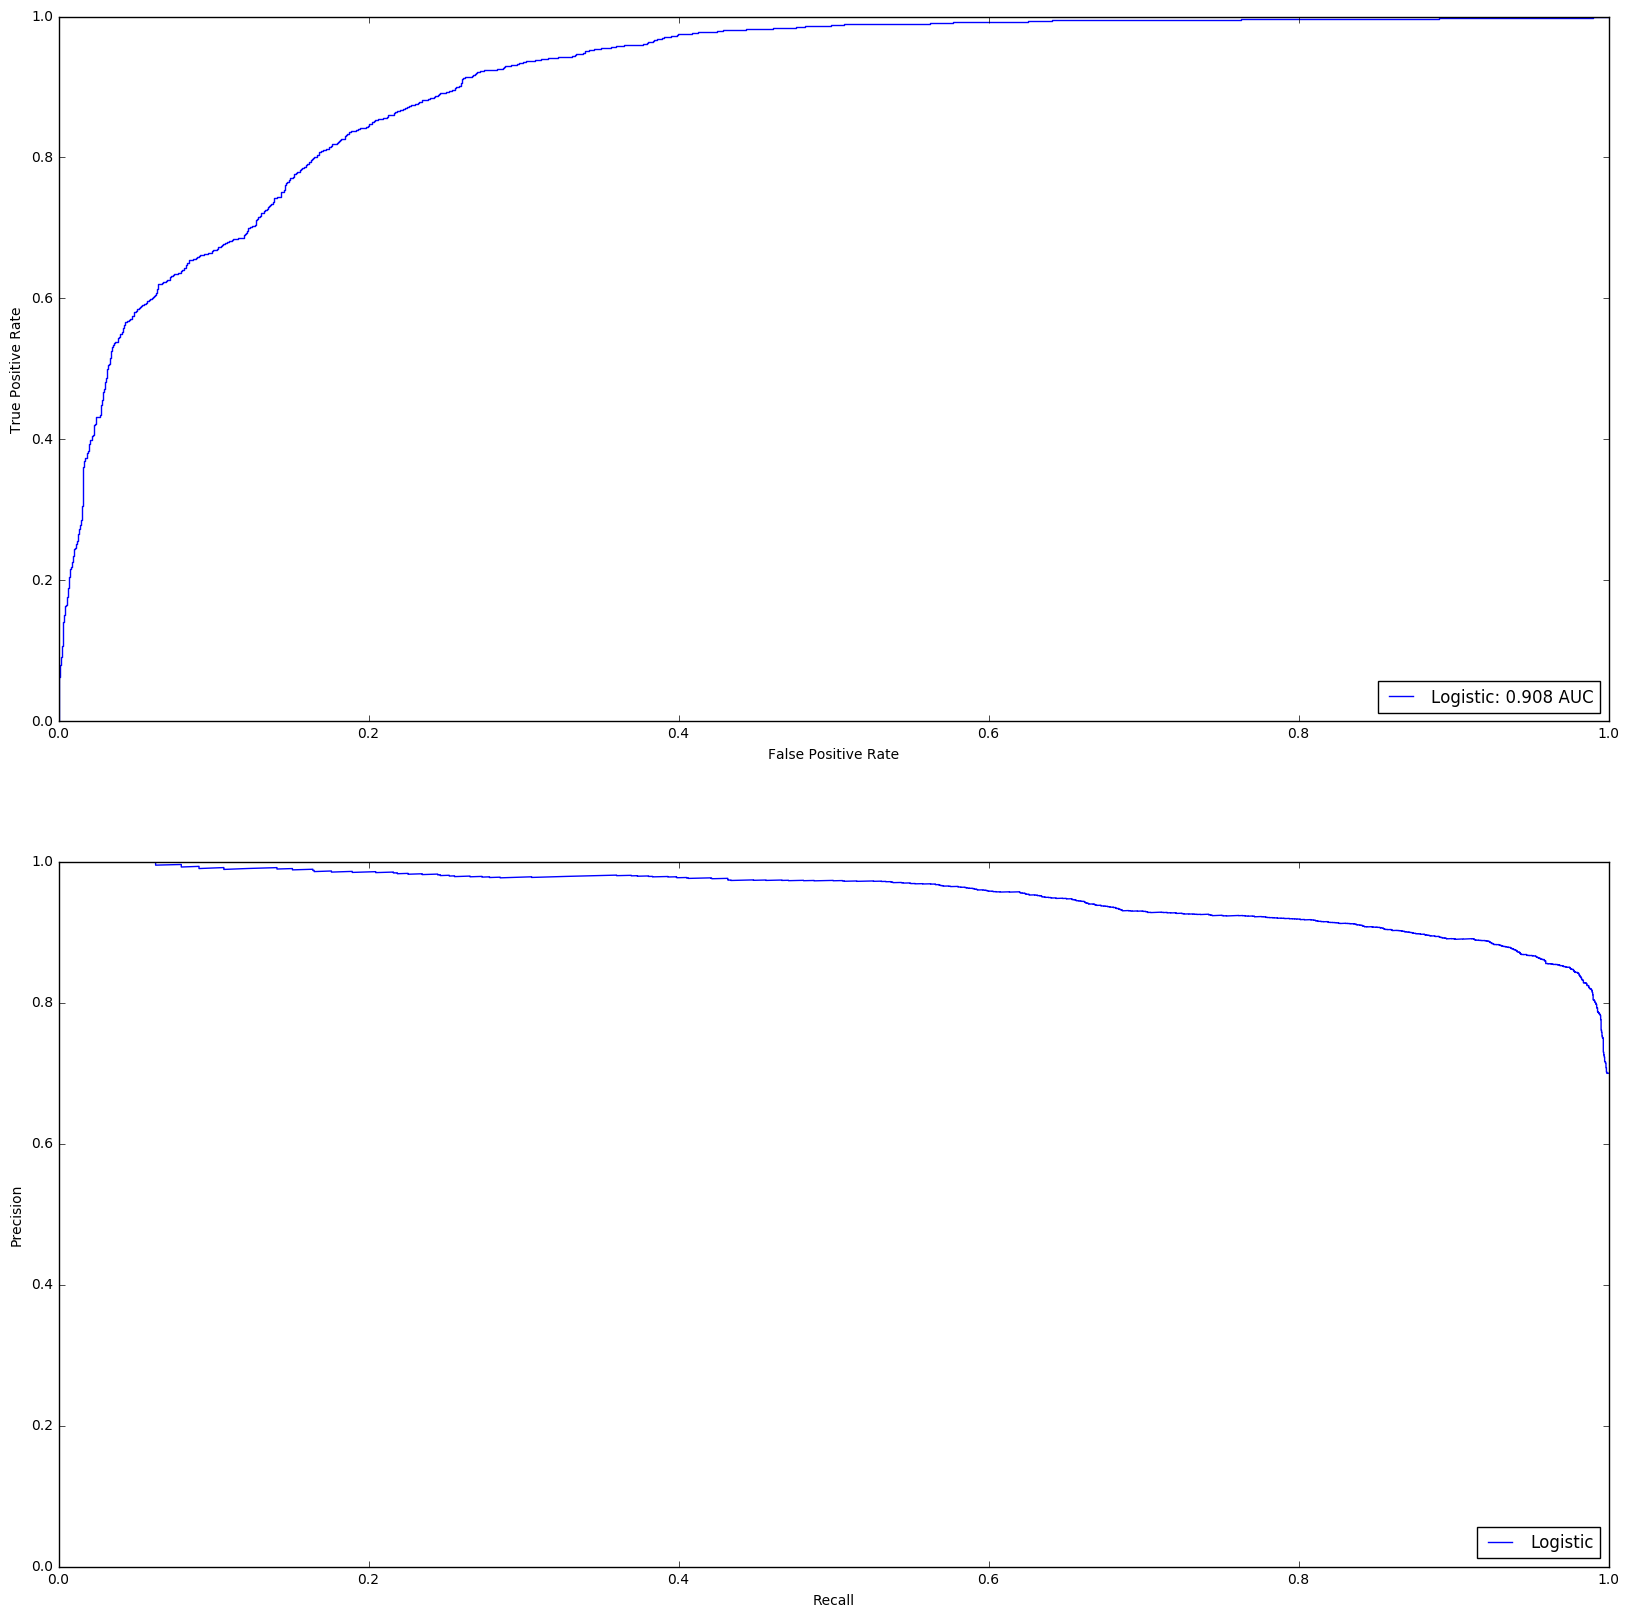

In [11]:
datasets = vessel_scoring.models.load_data()

for gear, title in GEARS:
    X_test = test_data[title]

    spec = vessel_scoring.models.untrained_models['Logistic']
    mdl = vessel_scoring.models.train_model('Logistic', spec, datasets)
    
    display(HTML("<h2>{}</h2>".format(title)))
      
    compare_models([("Logistic", mdl)], X_test)
    
    display(HTML("<hr/>"))

In [12]:
GEARS

[('ps', 'Purse seiners'),
 ('trawl', 'Trawlers'),
 ('longliner', 'Long liners'),
 ('longliner', 'Long liners - crowd')]

Training Logistic...


(0, 1)

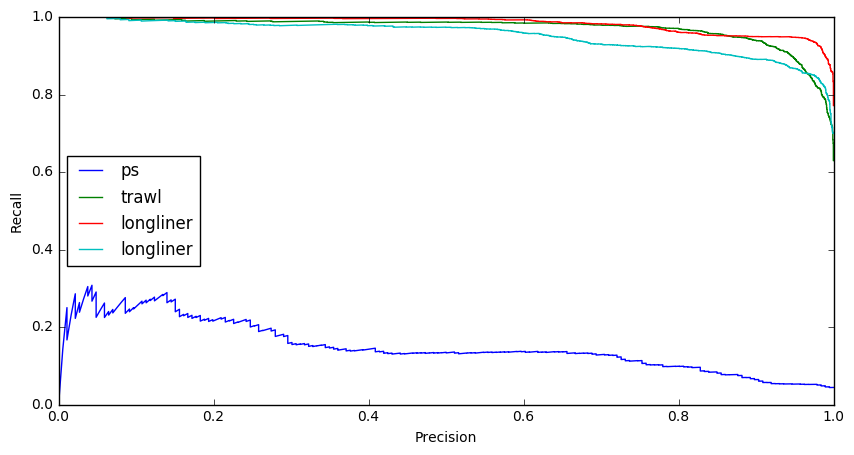

In [13]:
f, a1 = plt.subplots(1, figsize=(10,5))

spec = vessel_scoring.models.untrained_models['Logistic']
mdl = vessel_scoring.models.train_model('Logistic', spec, datasets)  

for gear, title in GEARS:
    td = test_data[title]

    score = mdl.predict_proba(td)[:,1]
    precisions, recalls, thresholds = metrics.precision_recall_curve(utils.is_fishy(td), score)
    a1.plot(recalls, precisions, label=gear)
a1.set_ylabel('Recall')
a1.set_xlabel('Precision')
a1.legend(loc="center left")
a1.set_ylim(0, 1)